## Prepare

In [1]:
# All the imports
import acquire as a
import prepare as p
import numpy as np
import pandas as pd
# ML stuff:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, \
export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
#plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

Questions:
1.) Does paperless billing affect churn
2.) does streaming tv affect churn
3.) does streaming movies affect churn
4.) does tech support affect churn

In [2]:
#obtaining data
telco = a.get_telco_data()

this file exists, reading from csv


In [3]:
#prepping the data
telco = p.prep_telco(telco)
telco.head(3).T

,0,1,2
customer_id,0002-ORFBO,0003-MKNFE,0004-TLHLJ
gender,Female,Male,Male
senior_citizen,0,0,0
partner,Yes,No,No
dependents,Yes,No,No
tenure,9,9,4
phone_service,Yes,Yes,Yes
multiple_lines,No,Yes,No
online_security,No,No,No
online_backup,Yes,No,No


In [4]:
#adjusting for monthly_charges having invalid data types
telco.monthly_charges.isna()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: monthly_charges, Length: 7043, dtype: bool

In [5]:
#checking to see what columns need to be changed
telco.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            7043 non-null   object 
 1   gender                 7043 non-null   object 
 2   senior_citizen         7043 non-null   int64  
 3   partner                7043 non-null   object 
 4   dependents             7043 non-null   object 
 5   tenure                 7043 non-null   int64  
 6   phone_service          7043 non-null   object 
 7   multiple_lines         7043 non-null   object 
 8   online_security        7043 non-null   object 
 9   online_backup          7043 non-null   object 
 10  device_protection      7043 non-null   object 
 11  tech_support           7043 non-null   object 
 12  streaming_tv           7043 non-null   object 
 13  streaming_movies       7043 non-null   object 
 14  paperless_billing      7043 non-null   object 
 15  monthly_c

In [6]:
#fixing the internet service type column
telco['internet_service_type'] = telco['internet_service_type'].fillna('None')

In [7]:
#splitting data into train/val/test
telco_train, telco_val, telco_test = p.splitting_data(telco, 'churn')

In [8]:
#encoding split data so that we can use encoded columns with binary outputs
train_encode, val_encode, test_encode = p.preprocess_telco(telco_train,telco_val,telco_test)

In [9]:
#fixing the customer id column for modeling later
train_encode = train_encode.set_index(['customer_id'])
val_encode = val_encode.set_index(['customer_id'])
test_encode = test_encode.set_index(['customer_id'])

In [10]:
#X and y values for train
X_train, y_train = train_encode.drop(columns='churn_Yes'), \
train_encode.churn_Yes


In [11]:
#X and y values for validate
X_val, y_val = val_encode.drop(columns='churn_Yes'), \
val_encode.churn_Yes

In [12]:
#X and y values for test
X_test, y_test = test_encode.drop(columns='churn_Yes'), \
test_encode.churn_Yes

In [13]:
# replaces values in the total charges column with a blank space to 0.0
telco.total_charges = telco.total_charges.str.replace(' ','0.0')

In [14]:
# changes total_charges to a float instead of an object
telco['total_charges'] = (telco.total_charges + '0').astype(float)

In [15]:
#sets index to customer_id so I don't have to drop it
telco = telco.set_index(['customer_id'])

## EXPLORE

In [16]:
#Understanding baseline
baseline_percentage = (telco.churn == "No").mean()
print(f'The baseline of churn is {baseline_percentage}')

The baseline of churn is 0.7346301292063041


In [17]:
#setting the alpha
α = 0.05

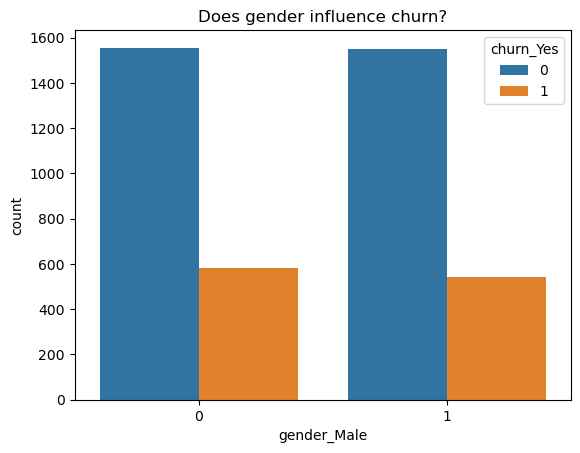

In [18]:
#building plots for my selected features
sns.countplot(data=train_encode, x='gender_Male', hue='churn_Yes')
plt.title("Does gender influence churn?")
plt.show()

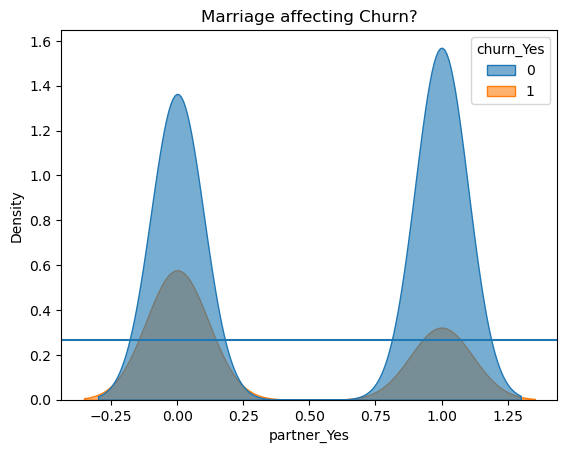

In [76]:
sns.kdeplot(data=train_encode, x='partner_Yes', hue='churn_Yes', fill=True, alpha=.6)
plt.title("Marriage affecting Churn?")
plt.axhline(population_churn, label="Population Churn Rate")
plt.show()

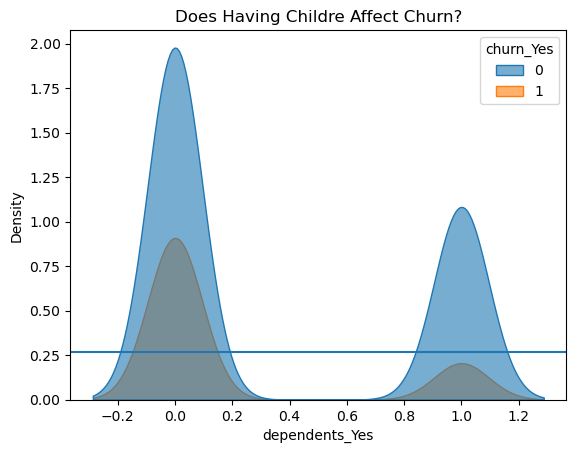

In [78]:
#sns.barplot(data=train_encode, x='dependents_Yes', y='churn_Yes')
sns.kdeplot(data=train_encode, x='dependents_Yes', hue='churn_Yes', fill=True, alpha=.6)
#plt.title("Marriage affecting Churn?")
#plt.show()
plt.title("Does Having Childre Affect Churn?")
plt.axhline(population_churn, label="Population Churn Rate")
plt.show()

In [21]:
# Filtering the dataset for customers with dependents and calculating churn rate
dependents_churn = telco[telco['dependents'] == 'Yes']['churn'].value_counts()
dependents_churn_no = telco[telco['dependents'] == 'No']['churn'].value_counts()

print(dependents_churn, dependents_churn_no)


churn
No     1784
Yes     326
Name: count, dtype: int64 churn
No     3390
Yes    1543
Name: count, dtype: int64


In [22]:
326/2110

0.15450236966824646

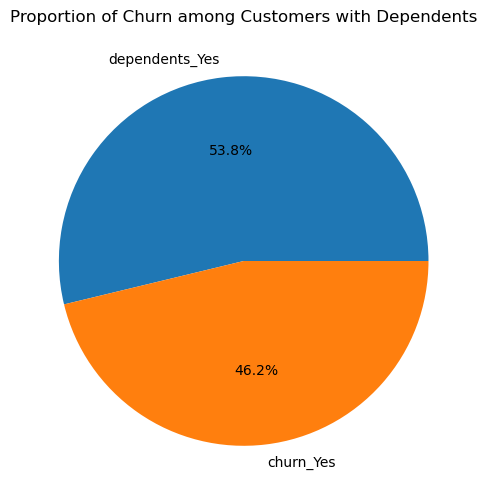

In [23]:
# Create a subset for 'dependents_Yes' and 'churn_Yes' columns
dependents_churn = train_encode[['dependents_Yes', 'churn_Yes']]

# Count the occurrences of each category
count_dependents_churn = dependents_churn.apply(pd.Series.value_counts).T

# Plotting a pie chart
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
plt.pie(count_dependents_churn[1], labels=count_dependents_churn.index, autopct='%1.1f%%')
plt.title("Proportion of Churn among Customers with Dependents")
plt.show()

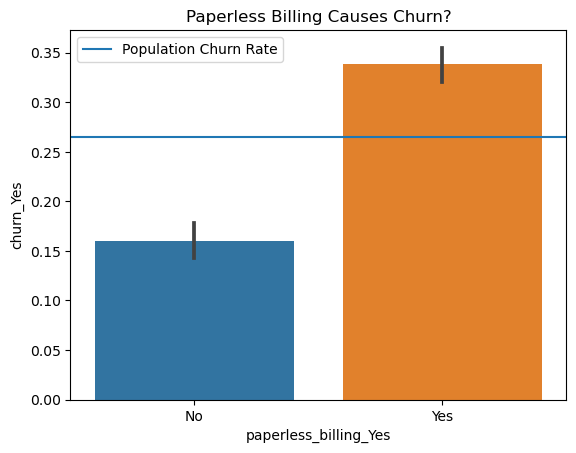

In [24]:
sns.barplot(data=train_encode, x='paperless_billing_Yes', y='churn_Yes')
plt.title("Paperless Billing Causes Churn?")
population_churn = train_encode.churn_Yes.mean()
plt.axhline(population_churn, label="Population Churn Rate")
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.legend()
plt.show()


In [25]:
# Let's run a chi squared to compare proportions, to have more confidence
null_hypothesis = "there is NO relationship between gender and churn"
alternative_hypothesis = "there is a relationship between gender and churn"

# Setup a crosstab of observed survival to pclass
observed_gender = pd.crosstab(train_encode.churn_Yes, train_encode.gender_Male)

chi2, p, degf, expected = stats.chi2_contingency(observed_gender)

if p < α:
    print(f"Reject the null hypothesis that, {null_hypothesis}")
    print(f"Sufficient evidence to move forward understanding that, {alternative_hypothesis}")
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Fail to reject the null
Insufficient evidence to reject the null


0.34677390607565795

In [26]:
# Let's run a chi squared to compare proportions, to have more confidence
α = 0.05
null_hypothesis = "there is NO relationship between having a parnter and churn"
alternative_hypothesis = "there is a relationship between having a parnter and churn"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train_encode.churn_Yes, train_encode.partner_Yes)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < α:
    print(f"Reject the null hypothesis that, {null_hypothesis}")
    print(f"Sufficient evidence to move forward understanding that, {alternative_hypothesis}")
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that, there is NO relationship between having a parnter and churn
Sufficient evidence to move forward understanding that, there is a relationship between having a parnter and churn


3.3117883244850396e-24

In [27]:
# Let's run a chi squared to compare proportions, to have more confidence
α = 0.05
null_hypothesis = "there is NO relationship between having dependents and churn"
alternative_hypothesis = "there is a relationship between having dependents and churn"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train_encode.churn_Yes, train_encode.dependents_Yes)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < α:
    print(f"Reject the null hypothesis that, {null_hypothesis}")
    print(f"Sufficient evidence to move forward understanding that, {alternative_hypothesis}")
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that, there is NO relationship between having dependents and churn
Sufficient evidence to move forward understanding that, there is a relationship between having dependents and churn


6.84215803296947e-26

In [28]:
# Let's run a chi squared to compare proportions, to have more confidence
α = 0.05
null_hypothesis = "there is NO relationship between paperless billing and churn"
alternative_hypothesis = "there is a relationship between paperless billing and churn"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train_encode.churn_Yes, train_encode.paperless_billing_Yes)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < α:
    print(f"Reject the null hypothesis that, {null_hypothesis}")
    print(f"Sufficient evidence to move forward understanding that, {alternative_hypothesis}")
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that, there is NO relationship between paperless billing and churn
Sufficient evidence to move forward understanding that, there is a relationship between paperless billing and churn


5.802667394637569e-38

In [85]:
# DECISION TREE
# creates a for loop iterating 20 times with a different max depth each iteration.
for x in range(1,24):
    #create the decision tree object
    tree = DecisionTreeClassifier(max_depth=x, random_state=24)
    #fit the object only on TRAIN DATA!
    tree.fit(X_train, y_train)
    #calculate the accuracy for train and validate
    acc_train_tree = tree.score(X_train, y_train)
    acc_validate_tree = tree.score(X_val, y_val)
    print(f'max depth of {x}, the accuracy on train = {round(acc_train_tree,4)}, on val = {round(acc_validate_tree,4)}')

max depth of 1, the accuracy on train = 0.7347, on val = 0.7346
max depth of 2, the accuracy on train = 0.7922, on val = 0.7906
max depth of 3, the accuracy on train = 0.7922, on val = 0.7906
max depth of 4, the accuracy on train = 0.7995, on val = 0.7892
max depth of 5, the accuracy on train = 0.8128, on val = 0.7842
max depth of 6, the accuracy on train = 0.8194, on val = 0.7835
max depth of 7, the accuracy on train = 0.8286, on val = 0.7757
max depth of 8, the accuracy on train = 0.84, on val = 0.77
max depth of 9, the accuracy on train = 0.8604, on val = 0.7523
max depth of 10, the accuracy on train = 0.8812, on val = 0.7473
max depth of 11, the accuracy on train = 0.8996, on val = 0.7289
max depth of 12, the accuracy on train = 0.9183, on val = 0.7282
max depth of 13, the accuracy on train = 0.9359, on val = 0.7253
max depth of 14, the accuracy on train = 0.9515, on val = 0.7097
max depth of 15, the accuracy on train = 0.9645, on val = 0.7189
max depth of 16, the accuracy on train

based on this, I would conclude that the best model out of these is a max depth of 2 or 3

In [55]:
y_pred = tree.predict(X_train)
y_pred[:10]

array([1, 0, 1, 1, 1, 0, 0, 0, 0, 0])

In [56]:
tree.score(X_train, y_train)

0.9990532544378699

In [57]:
pd.crosstab(y_train, y_pred)

col_0,0,1
churn_Yes,,
0,3104,0
1,4,1117


In [60]:
for x in range(1, 27):
    # Create the RandomForestClassifier object
    forest = RandomForestClassifier(n_estimators=100, max_depth=x, random_state=24)
    
    # Fit the model on the training data
    forest.fit(X_train, y_train)
    
    # Calculate the accuracy
    acc_forest = forest.score(X_train, y_train)
    acc_forest_val = forest.score(X_val, y_val)
    print(f'max depth of {x}, the accuracy train = {round(acc_forest,4)}, val = {round(acc_forest_val,4)}')
    # print(f'With a max depth of {x}, the accuracy is {round(acc_forest, 2)}')


max depth of 1, the accuracy train = 0.7347, val = 0.7346
max depth of 2, the accuracy train = 0.7652, val = 0.7679
max depth of 3, the accuracy train = 0.7893, val = 0.7821
max depth of 4, the accuracy train = 0.7986, val = 0.7991
max depth of 5, the accuracy train = 0.8019, val = 0.797
max depth of 6, the accuracy train = 0.8121, val = 0.8041
max depth of 7, the accuracy train = 0.8218, val = 0.802
max depth of 8, the accuracy train = 0.8369, val = 0.8055
max depth of 9, the accuracy train = 0.8568, val = 0.7942
max depth of 10, the accuracy train = 0.8826, val = 0.8013
max depth of 11, the accuracy train = 0.9122, val = 0.7956
max depth of 12, the accuracy train = 0.9472, val = 0.7842
max depth of 13, the accuracy train = 0.9733, val = 0.7871
max depth of 14, the accuracy train = 0.9872, val = 0.7793
max depth of 15, the accuracy train = 0.9927, val = 0.78
max depth of 16, the accuracy train = 0.9957, val = 0.7764
max depth of 17, the accuracy train = 0.9976, val = 0.78
max depth of

based on these samples, I would conclude that a max depth of 5

In [79]:
forest_best = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=24)

In [61]:
#make it
lr = LogisticRegression()
features = ['partner_Yes', 'dependents_Yes', 'paperless_billing_Yes', 'gender_Male']
#fit it
lr.fit(X_train[features], y_train)
lr.score(X_train[features], y_train)

0.7346745562130178

In [97]:
test_encode.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
customer_id,,,,,,,,,,,,,,,,,,,,,
7696-CFTAT,0,37,19,726.1,1,1,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
2388-LAESQ,1,72,114,8317.95,0,1,0,1,0,1,...,1,1,0,0,1,1,0,0,0,0
8217-QYOHV,0,5,55,266.95,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
4393-OBCRR,0,3,20,71.2,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1
0337-CNPZE,0,41,106,4443.45,0,0,0,1,0,1,...,1,1,1,0,0,1,0,0,1,0


In [101]:
import pandas as pd

# Assuming forest_best is your trained model
probabilities = forest_best.predict_proba(test_encode.drop(columns='churn_Yes'))

# Probabilities for the positive class (churn_Yes)
churn_probabilities = probabilities[:, 1]  # assuming churn_Yes is at index 1

# Create a DataFrame with customer IDs
predictions_df = pd.DataFrame({'ID': test_encode.index})  # Replace 'ID_column' with your actual ID column

# Add Predictions and Churn_Probability columns to the DataFrame
predictions_df['Predictions'] = forest_best.predict(test_encode.drop(columns='churn_Yes'))
predictions_df['Churn_Probability'] = churn_probabilities

# You can also create a column indicating whether the customer churned based on a threshold
threshold = 0.5  # Adjust the threshold as needed
predictions_df['Churn_Prediction'] = (churn_probabilities > threshold).astype(int)

# Save the predictions DataFrame to a CSV file
predictions_df.to_csv('predictions_random_forest.csv', index=False)

In the real world, I can expect my model to predict churn based off my selected features 78.99% of the time